In [5]:
import pandas as pd

import transformers
from transformers import BertModel, BertTokenizer, RobertaConfig, RobertaModel
import torch
import torch.nn as nn
from dont_patronize_me import DontPatronizeMe
import numpy as np
import seaborn as sns
import collections
import operator
import re
from collections import defaultdict
from nltk.stem import PorterStemmer
import spacy

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS


from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader

RANDOM_SEED = 42



In [6]:
dpm = DontPatronizeMe('.', '.')
dpm = DontPatronizeMe('../datasets/raw_data/', '../datasets/raw_data/dontpatronizeme_pcl.tsv')

dpm.load_task1()

dpm2 = DontPatronizeMe('.', '.')
dpm2 = DontPatronizeMe('../datasets/raw_data/', '../dataset/raw_data/dontpatronizeme_categories.tsv')

dpm2.load_task2()

Map of label to numerical label:
{'Unbalanced_power_relations': 0, 'Shallow_solution': 1, 'Presupposition': 2, 'Authority_voice': 3, 'Metaphors': 4, 'Compassion': 5, 'The_poorer_the_merrier': 6}


In [7]:
df = dpm.train_task1_df
df_cate = dpm2.train_task2_df
df_cate['label_class'] = df_cate['label']

In [8]:
df_new = pd.merge(df, df_cate[['par_id', 'label_class']], how='left', left_on="par_id", right_on="par_id")
df_new['len_text'] = df_new['text'].apply(lambda d: len(d))
df_new['label_class'] = df_new['label_class'].apply(lambda d: d if isinstance(d, np.ndarray) else [0,0,0,0,0,0,0])

In [9]:
dpm_categories = pd.DataFrame(df_new['label_class'].tolist(), columns=['unbalanced_power', 'shallow_solution', 'presupposition', 'authority_voice', 'metaphor', 'compassion', 'the_poorer_merrier'])
df_new = pd.merge(df_new, dpm_categories, left_index=True, right_index=True)

In [10]:
result = pd.DataFrame(df_new['label'].value_counts()).reset_index()

result.columns = ['label', 'count']
result['total'] = 10469
result['percentage'] = round((result['count'] * 100/ result['total']), 2)



In [11]:
result

,label,count,total,percentage
0,0,9476,10469,90.51
1,1,993,10469,9.49


## Data Exploration

In [12]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

# make sure your downloaded the english model with "python -m spacy download en"
lemmatizer = spacy.load("en_core_web_sm")

# stemmer
porter = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/weijiechua/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
def preprocess_text(category, category_tf = True, condescending_only = True):
    # the code here only takes in label=1 and not stop word
    re_punctuation_string = '[\s\-,/.?:;()''""\']'
    stop_word = stopwords.words('english')
    useless_word = ['The','people','I']

    sentences_list = []
    corpus = []

    if condescending_only:
        df_dpm = df_new.loc[df_new['label'] != 0]
    else:
        df_dpm = df_new.loc[df_new['label'] == 0]
    if category_tf: 
        df_dpm = df_dpm.loc[df_dpm[CATEGORY] == 1]

    for sentence in df_dpm['text']:
        tokenized_sentence = re.split(re_punctuation_string, sentence)
        tokenized_sentence = list(filter(None, tokenized_sentence))
        sentences_list.append(tokenized_sentence)

    for sentence in sentences_list:
        lemmatized_sentence = lemmatizer(' '.join(sentence))
        new_sentence = []
        for word in lemmatized_sentence:
            corpus.append(word.lemma_)
    #corpus= [porter.stem(word.lower()) for sentence in sentences_list for word in sentence]


    my_dict=defaultdict(int)
    for word in corpus:
        if word not in stop_word and word not in useless_word:
            my_dict[word]+=1

    corpus_text= " ".join(corpus)

    od = collections.OrderedDict(sorted(my_dict.items(), key=lambda item: item[1]), reversed=True)

    return corpus, corpus_text, od

def draw_bar_chart(od):
    keys = list(od.keys())[-11:-1]
    print(keys)
    # get values in the same order as keys, and parse percentage values
    vals = [int(od[k]) for k in keys]
    g = sns.barplot(x=keys, y=vals)
    g.set_ylabel("Frequency of word in condescending sentence")
    plt.xticks(rotation=45)

In [14]:
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");
    
def draw_word_cloud(corpus_text):
    wordcloud = WordCloud(width= 3000, height = 2000, random_state=1, background_color='salmon', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(corpus_text)
    # Plot
    plot_cloud(wordcloud)

In [15]:
cate_available = ['unbalanced_power', 'shallow_solution', 'presupposition', 'authority_voice', 'metaphor', 'compassion', 'the_poorer_merrier']
CATEGORY = cate_available[0]
print(CATEGORY)

unbalanced_power


In [16]:
# This is where we process the data
# change category_tf to True, and adjust the CATEGORY AT ONE CELL ABOVE if we want to display word cloud for that particular category
# change condescending_only to True if we only want to look at condescending texts
corpus, corpus_text, od = preprocess_text(CATEGORY, category_tf=False, condescending_only=True)

In [17]:
list(od.keys())[-50:]

['society',
 'person',
 'care',
 'way',
 'like',
 'day',
 'immigrant',
 'poverty',
 'world',
 'even',
 'support',
 'hope',
 'time',
 'food',
 'man',
 'go',
 'take',
 'government',
 'well',
 'home',
 'community',
 'see',
 'hopeless',
 'also',
 'provide',
 'get',
 'live',
 'n',
 'would',
 'come',
 'many',
 'one',
 'vulnerable',
 'year',
 'disabled',
 'work',
 'country',
 'make',
 'refugee',
 'give',
 'woman',
 'life',
 'homeless',
 'help',
 'child',
 'poor',
 'say',
 'family',
 'need',
 'reversed']

['give', 'woman', 'life', 'homeless', 'help', 'child', 'poor', 'say', 'family', 'need']


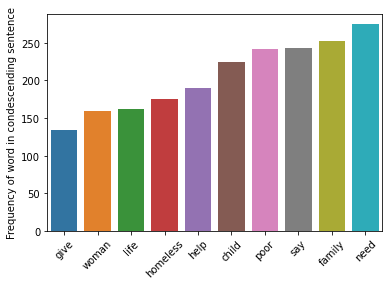

In [18]:
draw_bar_chart(od)

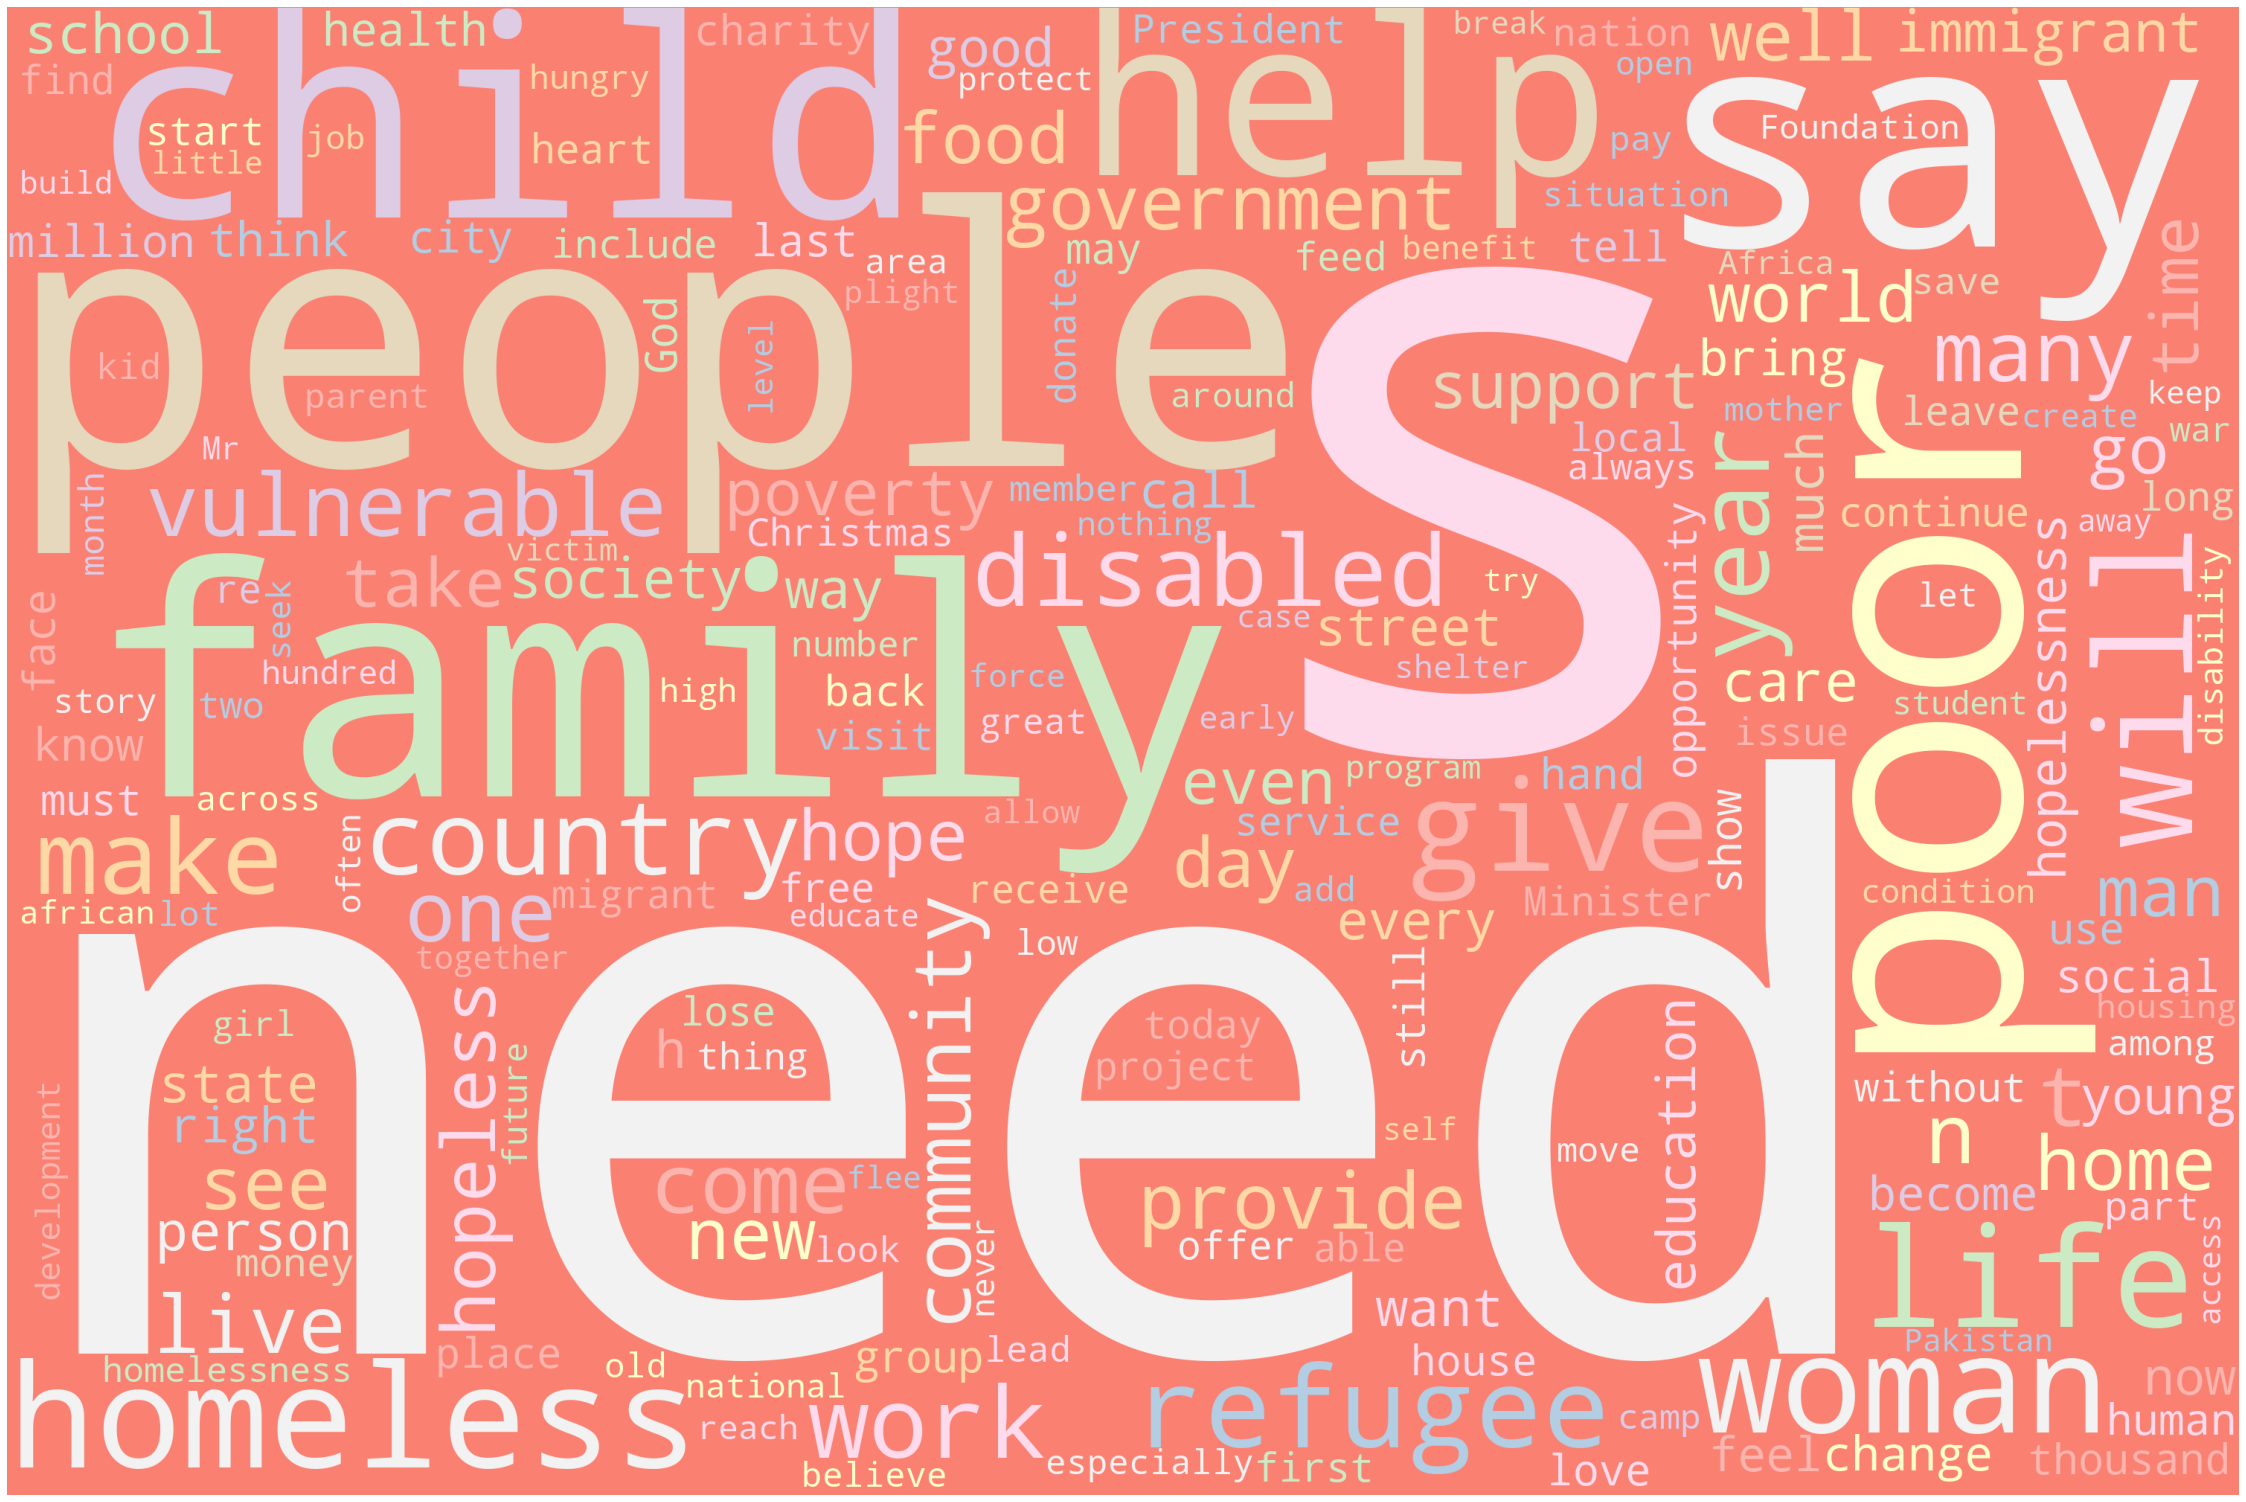

In [19]:
# non consdescending only
draw_word_cloud(corpus_text)

# Individual Category

In [20]:
cate_available_keyword = ['label', 'unbalanced_power', 'shallow_solution', 'presupposition', 'authority_voice', 'metaphor', 'compassion', 'the_poorer_merrier', 'keyword']
cate_available_keyword_count = ['unbalanced_power', 'shallow_solution', 'presupposition', 'authority_voice', 'metaphor', 'compassion', 'the_poorer_merrier', 'keyword', 'par_id']
cate_available_keyword_len = ['unbalanced_power', 'shallow_solution', 'presupposition', 'authority_voice', 'metaphor', 'compassion', 'the_poorer_merrier', 'len_text']
cate_available_keyword_w_label = ['unbalanced_power', 'shallow_solution', 'presupposition', 'authority_voice', 'metaphor', 'compassion', 'the_poorer_merrier']
df_label1 = df_new.loc[df_new['label'] == 1]

df_cate = df_label1[cate_available_keyword].groupby(['label', 'keyword']).agg(['sum']).reset_index()

In [21]:
df_cate

,label,keyword,unbalanced_power,shallow_solution,presupposition,authority_voice,metaphor,compassion,the_poorer_merrier
,,,sum,sum,sum,sum,sum,sum,sum
0,1,disabled,54,15,18,20,11,28,8
1,1,homeless,136,52,25,23,40,84,3
2,1,hopeless,56,5,63,35,32,108,3
3,1,immigrant,18,3,10,6,3,21,2
4,1,in-need,162,53,14,31,23,52,2
5,1,migrant,23,4,6,8,6,22,4
6,1,poor-families,110,29,42,39,42,68,6
7,1,refugee,60,19,16,15,15,45,4
8,1,vulnerable,66,8,15,29,19,29,1


In [22]:
df_new[['label', 'len_text']].groupby(['label']).agg(['mean']).reset_index()

,label,len_text
,,mean
0,0,265.395737
1,1,288.454179


In [23]:
df_label1

,par_id,art_id,keyword,country,text,label,orig_label,label_class,len_text,unbalanced_power,shallow_solution,presupposition,authority_voice,metaphor,compassion,the_poorer_merrier
32,33,@@8301323,disabled,pk,Arshad said that besides learning many new asp...,1,2,"[1, 0, 0, 0, 0, 0, 0]",244,1,0,0,0,0,0,0
33,34,@@24150149,disabled,ng,Fast food employee who fed disabled man become...,1,3,"[1, 1, 0, 0, 0, 0, 0]",66,1,1,0,0,0,0,0
41,42,@@4591694,hopeless,jm,Vanessa had feelings of hopelessness in her fi...,1,3,"[0, 0, 0, 0, 0, 1, 0]",295,0,0,0,0,0,1,0
76,77,@@22454828,homeless,nz,"In September , Major Nottle set off on foot fr...",1,3,"[1, 1, 0, 0, 0, 0, 0]",129,1,1,0,0,0,0,0
82,83,@@4672144,homeless,pk,The demographics of Pakistan and India are ver...,1,3,"[1, 1, 0, 0, 0, 0, 0]",573,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10444,10445,@@3923193,refugee,gb,More than 150 volunteers spent the night in ' ...,1,3,"[0, 1, 0, 0, 0, 0, 0]",112,0,1,0,0,0,0,0
10453,10454,@@22338535,vulnerable,ie,""""""" We are challenged , I suggest , to turn th...",1,4,"[1, 1, 0, 0, 1, 1, 0]",244,1,1,0,0,1,1,0
10466,10467,@@20282330,in-need,ng,""""""" She has one huge platform , and informatio...",1,3,"[1, 0, 0, 0, 0, 0, 0]",286,1,0,0,0,0,0,0
10467,10468,@@16753236,hopeless,in,""""""" Anja Ringgren Loven I ca n't find a word t...",1,4,"[1, 0, 1, 0, 0, 1, 0]",502,1,0,1,0,0,1,0


In [24]:
df_label1[cate_available_keyword_len].groupby(cate_available_keyword_w_label).agg(['mean']).reset_index()

,unbalanced_power,shallow_solution,presupposition,authority_voice,metaphor,compassion,the_poorer_merrier,len_text
,,,,,,,,mean
0,0,0,0,0,0,0,1,393.800000
1,0,0,0,0,0,1,0,249.338462
2,0,0,0,0,0,1,1,596.500000
3,0,0,0,0,1,0,0,202.666667
4,0,0,0,0,1,0,1,260.000000
...,...,...,...,...,...,...,...,...
68,1,1,1,0,0,1,0,257.500000
69,1,1,1,0,1,0,0,324.000000
70,1,1,1,0,1,1,0,328.000000


In [25]:
df_label1[cate_available_keyword_len].groupby(cate_available_keyword_w_label)

In [26]:
df_new[df_new['orig_label'] == '4']

,par_id,art_id,keyword,country,text,label,orig_label,label_class,len_text,unbalanced_power,shallow_solution,presupposition,authority_voice,metaphor,compassion,the_poorer_merrier
117,118,@@24885862,in-need,za,"""This is the rhetoric of what anthropologist L...",1,4,"[1, 0, 0, 1, 0, 1, 0]",348,1,0,0,1,0,1,0
153,154,@@20663936,disabled,ng,When some people feel causing problem for some...,1,4,"[0, 0, 1, 1, 1, 1, 0]",496,0,0,1,1,1,1,0
156,157,@@21712008,poor-families,ca,We are alarmed to learn of your recently circu...,1,4,"[1, 1, 0, 0, 1, 1, 0]",601,1,1,0,0,1,1,0
186,187,@@24814760,in-need,bd,""""""" We share a global responsibility to respon...",1,4,"[1, 0, 0, 0, 0, 0, 0]",290,1,0,0,0,0,0,0
194,195,@@4478900,homeless,gb,Housing Minister Grant Shapps added : ' The pl...,1,4,"[1, 0, 0, 1, 0, 0, 0]",133,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10351,10352,@@21102155,poor-families,lk,The next immediate problem that cropped up was...,1,4,"[1, 0, 0, 0, 0, 1, 0]",398,1,0,0,0,0,1,0
10378,10379,@@30026901,poor-families,za,""""""" Many children from poor families and worki...",1,4,"[0, 0, 1, 1, 1, 1, 0]",266,0,0,1,1,1,1,0
10399,10400,@@25998036,homeless,pk,""""""" They 're a little bit behind me I think , ...",1,4,"[1, 1, 0, 0, 0, 0, 0]",352,1,1,0,0,0,0,0
10453,10454,@@22338535,vulnerable,ie,""""""" We are challenged , I suggest , to turn th...",1,4,"[1, 1, 0, 0, 1, 1, 0]",244,1,1,0,0,1,1,0


In [27]:
df_new.iloc[32]

par_id                                                               33
art_id                                                        @@8301323
keyword                                                        disabled
country                                                              pk
text                  Arshad said that besides learning many new asp...
label                                                                 1
orig_label                                                            2
label_class                                       [1, 0, 0, 0, 0, 0, 0]
len_text                                                            244
unbalanced_power                                                      1
shallow_solution                                                      0
presupposition                                                        0
authority_voice                                                       0
metaphor                                                        

In [28]:
df_new.iloc[117].text

'"This is the rhetoric of what anthropologist Laura Agust ? n calls the "" rescue industry "" - a term used to describe people and institutions who conceptualize all sex workers as victims in need of saving . Catherine MacKinnon has argued , for example , that "" in prostitution , women have sex with men they would never otherwise have sex with ."'

In [29]:
#df_new.to_csv("df_preprocessing.csv")

### 3.1 Part 1.1) Analysis of the class labels

df_new=  pd.read_csv("../datasets/raw_data/df_preprocessing.csv")

In [30]:
df_new=  pd.read_csv("../datasets/raw_data/df_preprocessing.csv")

In [31]:
df_new

,Unnamed: 0,par_id,art_id,keyword,country,text,label,orig_label,label_class,len_text,unbalanced_power,shallow_solution,presupposition,authority_voice,metaphor,compassion,the_poorer_merrier
0,0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0,0,"[0, 0, 0, 0, 0, 0, 0]",620,0,0,0,0,0,0,0
1,1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0,0,"[0, 0, 0, 0, 0, 0, 0]",237,0,0,0,0,0,0,0
2,2,3,@@16584954,immigrant,ie,"""White House press secretary Sean Spicer said ...",0,0,"[0, 0, 0, 0, 0, 0, 0]",162,0,0,0,0,0,0,0
3,3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0,0,"[0, 0, 0, 0, 0, 0, 0]",162,0,0,0,0,0,0,0
4,4,5,@@1494111,refugee,ca,""""""" Just like we received migrants fleeing El ...",0,0,"[0, 0, 0, 0, 0, 0, 0]",277,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10464,10464,10465,@@14297363,women,lk,"""Sri Lankan norms and culture inhibit women fr...",0,1,"[0, 0, 0, 0, 0, 0, 0]",348,0,0,0,0,0,0,0
10465,10465,10466,@@70091353,vulnerable,ph,He added that the AFP will continue to bank on...,0,0,"[0, 0, 0, 0, 0, 0, 0]",258,0,0,0,0,0,0,0
10466,10466,10467,@@20282330,in-need,ng,""""""" She has one huge platform , and informatio...",1,3,[1 0 0 0 0 0 0],286,1,0,0,0,0,0,0
10467,10467,10468,@@16753236,hopeless,in,""""""" Anja Ringgren Loven I ca n't find a word t...",1,4,[1 0 1 0 0 1 0],502,1,0,1,0,0,1,0


In [32]:
result = df_new[['orig_label', 'par_id']].groupby(['orig_label']).agg(['count']).reset_index()

#result = pd.DataFrame(df_new['label'].value_counts()).reset_index()

result.columns = ['original label', 'count']
result['total'] = 10468
result['percentage'] = round((result['count'] * 100/ result['total']), 2)

In [33]:
result

,original label,count,total,percentage
0,0,8529,10468,81.48
1,1,947,10468,9.05
2,2,144,10468,1.38
3,3,458,10468,4.38
4,4,391,10468,3.74


In [34]:
#df_new_lab1 = df_new[df_new['label'] == 1]
result = df_new[['label', 'keyword', 'par_id']].groupby(['label',  'keyword']).agg(['count']).reset_index()
result.columns = ['label', 'keyword', 'count']
result.loc[result['label'] == 1, 'total'] = 993
result.loc[result['label'] == 0, 'total'] = 9476
result['percentage'] = round((result['count'] * 100/ result['total']), 2)

In [35]:
result

,label,keyword,count,total,percentage
0,0,disabled,947,9476.0,9.99
1,0,homeless,899,9476.0,9.49
2,0,hopeless,881,9476.0,9.30
3,0,immigrant,1031,9476.0,10.88
4,0,in-need,906,9476.0,9.56
5,0,migrant,1053,9476.0,11.11
6,0,poor-families,759,9476.0,8.01
7,0,refugee,982,9476.0,10.36
8,0,vulnerable,1000,9476.0,10.55
9,0,women,1018,9476.0,10.74


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

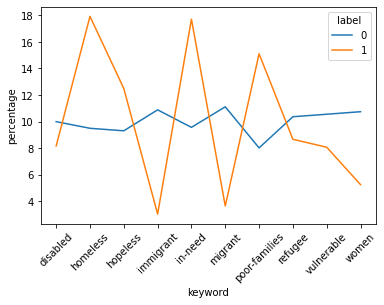

In [36]:
ax = sns.lineplot(data=result, x="keyword", y="percentage", hue="label")
plt.xticks(rotation=45)

In [37]:
#df_new_lab1 = df_new[df_new['label'] == 1]
result = df_new[['label', 'country', 'par_id']].groupby(['label',  'country']).agg(['count']).reset_index()
result.columns = ['label', 'country', 'count']
result.loc[result['label'] == 1, 'total'] = 993
result.loc[result['label'] == 0, 'total'] = 9476
result['percentage'] = round((result['count'] * 100/ result['total']), 2)

In [38]:
result

,label,country,count,total,percentage
0,0,au,504,9476.0,5.32
1,0,bd,468,9476.0,4.94
2,0,ca,484,9476.0,5.11
3,0,gb,483,9476.0,5.10
4,0,gh,448,9476.0,4.73
5,0,hk,461,9476.0,4.86
6,0,ie,485,9476.0,5.12
7,0,in,491,9476.0,5.18
8,0,jm,433,9476.0,4.57
9,0,ke,494,9476.0,5.21


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

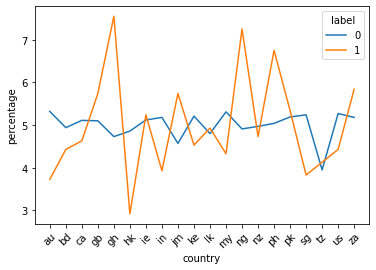

In [39]:
ax = sns.lineplot(data=result, x="country", y="percentage", hue="label")
plt.xticks(rotation=45)

In [40]:
result = df_new[['orig_label', 'len_text']].groupby(['orig_label']).agg(['mean']).reset_index()

#result = pd.DataFrame(df_new['label'].value_counts()).reset_index()

result.columns = ['original label', 'mean']
result['mean'] = round(result['mean'], 2)


In [41]:
result

,original label,mean
0,0,263.30
1,1,284.23
2,2,270.17
3,3,278.82
4,4,306.47


Text(0, 0.5, 'Mean of len of text')

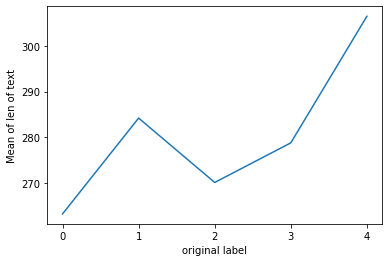

In [42]:
g = sns.lineplot(data=result, x="original label", y="mean")

g.set_xticks(range(5))
g.set_xticklabels(['0', '1', '2', '3', '4'])
g.set_ylabel("Mean of len of text")